# Preprocessing and Training: UHC Insurance Dataset



In the prior notebook we were able to clean our data, combine our insurance dataset with CMS datasets alongside creating new features. In addition exploratory analysis was performed in the prior notebook.

In this notebook we will pre-process the data and create some basic models. As always, we will import the libraries we intend to work with.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
import pyarrow as pa

## Import data

Let us import the dataframes we created in the prior notebook.

In [7]:
path = 'data'
obj = os.scandir(path)
l = [entry for entry in obj]
df_dict = {}

for entry in l:
    p = entry.name[0:-8]
    df_dict[p] = pd.read_parquet('data/'+entry.name, engine='pyarrow')

The procedure I selected was 

In [8]:
procedure = 'CPT58150'
df_dict[procedure].head().T

,0,1,2,3,4
ccn,290003,290039,290007,360144,100168
Procedure,CPT 58150,CPT 58150,CPT 58150,CPT 58150,CPT 58150
State Code,NV,NV,NV,OH,FL
Rural Versus Urban,U,U,U,U,U
PSI_03,0.13266,0.13266,0.13266,0.13266,0.13266
PSI_06,0.184709,0.184709,0.184709,0.184709,0.184709
PSI_08,0.114236,0.114236,0.114236,0.114236,0.114236
PSI_09,1.56662,1.56662,1.56662,1.56662,1.56662
PSI_10,0.650623,0.650623,0.650623,0.650623,0.650623
PSI_11,9.818181,9.818181,9.818181,9.818181,9.818181


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_dict[procedure].drop(columns='negotiated_rates_median'), 
                                                    df_dict[procedure]['negotiated_rates_median'], test_size=0.3, 
                                                    random_state=47)

In [11]:
names_list = ['ccn', 'Procedure', 'State Code','Rural Versus Urban']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((303, 34), (130, 34))

In [12]:
X_train.dtypes

PSI_03                                                                         float64
PSI_06                                                                         float64
PSI_08                                                                         float64
PSI_09                                                                         float64
PSI_10                                                                         float64
PSI_11                                                                         float64
PSI_12                                                                         float64
PSI_13                                                                         float64
PSI_14                                                                         float64
PSI_15                                                                         float64
PSI_90                                                                         float64
HAI_1_SIR                                  

In [13]:
X_test.dtypes

PSI_03                                                                         float64
PSI_06                                                                         float64
PSI_08                                                                         float64
PSI_09                                                                         float64
PSI_10                                                                         float64
PSI_11                                                                         float64
PSI_12                                                                         float64
PSI_13                                                                         float64
PSI_14                                                                         float64
PSI_15                                                                         float64
PSI_90                                                                         float64
HAI_1_SIR                                  

In [14]:
train_mean = y_train.mean()
train_mean

1341.9522442244224

In [15]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[1341.95224422]])

In [17]:
def r_squared(y, ypred):
    """R-squared score.
    
    Calculate the R-squared, or coefficient of determination, of the input.
    
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y) 
    sum_sq_tot = np.sum((y - ybar)**2) 
    sum_sq_res = np.sum((y - ypred)**2) 
    R2 = 1.0 - (sum_sq_res / sum_sq_tot)
    return R2

In [18]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([1341.95224422, 1341.95224422, 1341.95224422, 1341.95224422,
       1341.95224422])

In [19]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([1341.95224422, 1341.95224422, 1341.95224422, 1341.95224422,
       1341.95224422])

In [20]:
r_squared(y_train, y_tr_pred)

0.0

In [21]:
y_te_pred = train_mean * np.ones(len(y_test))
r_squared(y_test, y_te_pred)

-0.029884001947960925

In [22]:
def mae(y, ypred):
    """Mean absolute error.
    
    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [23]:
mae(y_train, y_tr_pred)

256.40325708808507

In [24]:
mae(y_test, y_te_pred)

281.67419053059155

In [25]:
def mse(y, ypred):
    """Mean square error.
    
    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [26]:
mse(y_train, y_tr_pred)

109416.45312978195

In [27]:
mse(y_test, y_te_pred)

118129.22000760508

In [28]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([330.78157919, 343.69931627])

In [29]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.029884001947960925)

In [30]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(256.40325708808507, 281.67419053059155)

In [31]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(109416.45312978195, 118129.22000760508)

In [32]:
r2_score(y_train, y_tr_pred), r2_score(y_tr_pred, y_train)

(0.0, 0.0)

In [33]:
r2_score(y_test, y_te_pred), r2_score(y_te_pred, y_test)

(-0.029884001947960925, 0.0)

In [34]:
r_squared(y_train, y_tr_pred), r_squared(y_tr_pred, y_train)

C:\Users\Vignesh Selvakumaran\AppData\Local\Temp\ipykernel_6308\1498809234.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  R2 = 1.0 - (sum_sq_res / sum_sq_tot)


(0.0, -inf)

In [35]:
r_squared(y_test, y_te_pred), r_squared(y_te_pred, y_test)

C:\Users\Vignesh Selvakumaran\AppData\Local\Temp\ipykernel_6308\1498809234.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  R2 = 1.0 - (sum_sq_res / sum_sq_tot)


(-0.029884001947960925, -inf)

In [36]:
X_defaults_median = X_train.median()
X_defaults_median

PSI_03                                                                         2.820790e-01
PSI_06                                                                         1.862203e-01
PSI_08                                                                         9.199800e-02
PSI_09                                                                         2.028281e+00
PSI_10                                                                         8.255150e-01
PSI_11                                                                         6.828991e+00
PSI_12                                                                         3.124478e+00
PSI_13                                                                         4.076848e+00
PSI_14                                                                         8.013550e-01
PSI_15                                                                         8.344240e-01
PSI_90                                                                         9

In [37]:
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

In [38]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

In [39]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [40]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [41]:
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.18495714887451464, 0.010988883616369516)

In [42]:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(229.83363661073503, 261.7289035344566)

In [43]:
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(89179.09791893551, 113441.03951150838)

In [44]:
X_defaults_mean = X_train.mean()
X_defaults_mean

PSI_03                                                                         5.816773e-01
PSI_06                                                                         1.807251e-01
PSI_08                                                                         9.194465e-02
PSI_09                                                                         2.201691e+00
PSI_10                                                                         1.045467e+00
PSI_11                                                                         8.316468e+00
PSI_12                                                                         3.265608e+00
PSI_13                                                                         4.465767e+00
PSI_14                                                                         7.807314e-01
PSI_15                                                                         9.516514e-01
PSI_90                                                                         1

In [45]:
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)

In [46]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

In [47]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [48]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [49]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.18495714887451464, 0.010988883616369516)

In [50]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(229.83363661073503, 261.7289035344566)

In [51]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(89179.09791893551, 113441.03951150838)

In [52]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [53]:
hasattr(pipe, 'fit'), hasattr(pipe, 'predict')

(True, True)

In [54]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [55]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [56]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.18495714887451464, 0.010988883616369516)

In [57]:
median_r2

(0.18495714887451464, 0.010988883616369516)

In [58]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(229.83363661073503, 261.7289035344566)

In [59]:
median_mae

(229.83363661073503, 261.7289035344566)

In [60]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(89179.09791893551, 113441.03951150838)

In [61]:
median_mse

(89179.09791893551, 113441.03951150838)

In [62]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func=f_regression),
    LinearRegression()
)

In [63]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000020B5A4C4280>)),
                ('linearregression', LinearRegression())])

In [64]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [65]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.1051167802757218, -0.008770836676242233)

In [66]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(243.20936728067014, 273.10518361338524)

In [67]:
pipe15 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func=f_regression, k=15),
    LinearRegression()
)

In [68]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x0000020B5A4C4280>)),
                ('linearregression', LinearRegression())])

In [69]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [70]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.12108551901135411, -0.016025448787830188)

In [71]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(239.4213844063878, 274.05286020292806)

In [72]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [73]:
cv_scores = cv_results['test_score']
cv_scores

array([-0.02201717,  0.09620838,  0.01600219, -0.03819649, -0.12262421])

In [74]:
np.mean(cv_scores), np.std(cv_scores)

(-0.014125459154356946, 0.07140715082047258)

In [75]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([-0.16,  0.13])

In [76]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__keep_empty_features', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

In [77]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [78]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [79]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000020B5A4C4280>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [80]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [81]:
lr_grid_cv.best_params_

{'selectkbest__k': 6}

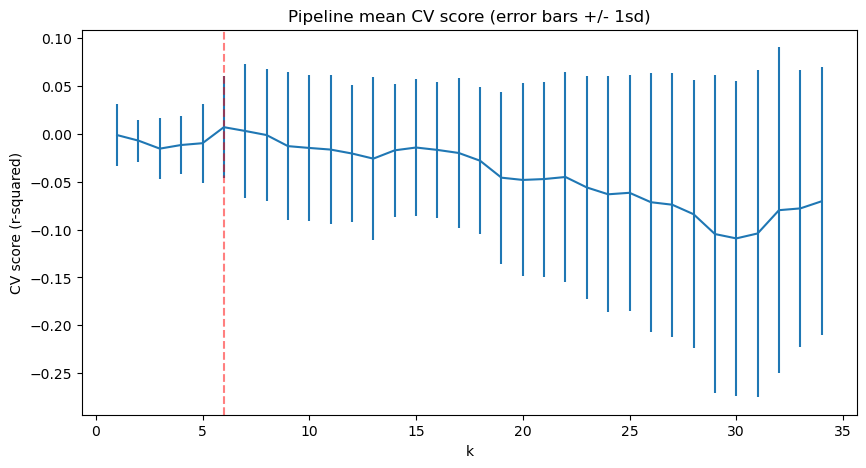

In [82]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [83]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [84]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

hospital_ratio                           48.053030
HAI_1_SIR                                42.857459
hospitals_per_100kcapita                 40.740605
Number of Interns and Residents (FTE)    21.697800
PSI_08                                   -7.326492
discharges_per_100kcapita               -41.759411
dtype: float64

In [85]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [86]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [87]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-0.28200218, -0.08276224, -0.05012757, -0.0870017 , -0.46973033])

In [88]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-0.1943248047611997, 0.1601829101073477)

In [89]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [90]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [91]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [92]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 379,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [93]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-0.27167312, -0.08100311, -0.03198504, -0.1002379 , -0.45323006])

In [94]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-0.1876258487993748, 0.15545974604156568)

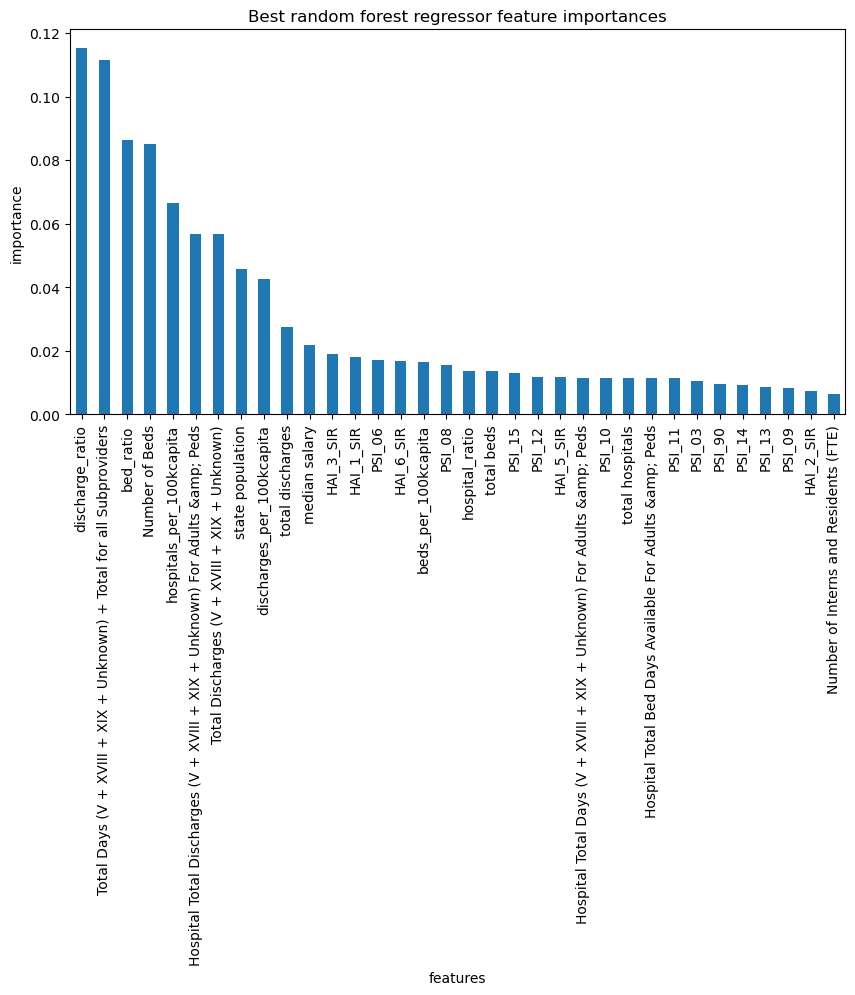

In [95]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [96]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [97]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(253.36515516248005, 31.404341486349857)

In [98]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

269.0729547810762

In [99]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [100]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(271.65487742693614, 18.741803516022756)

In [101]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

275.9846394357625

In [102]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

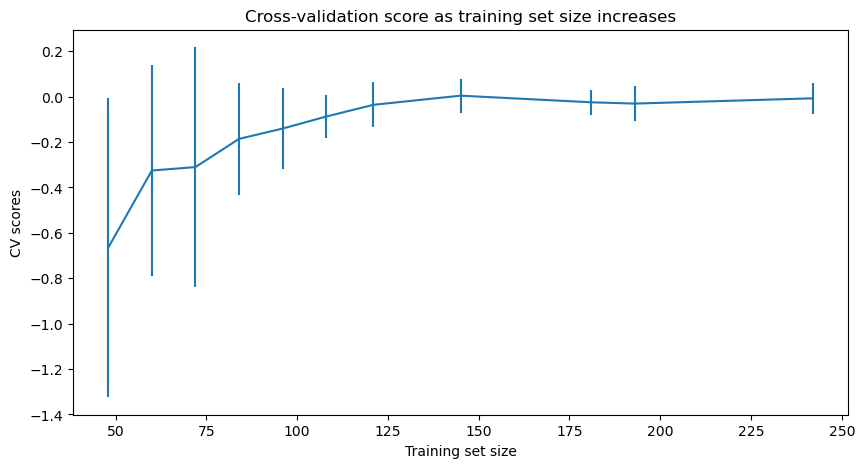

In [103]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

In [ ]:
best_model = rf_grid_cv.best_estimator_
best_model.version = 1
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()